In [284]:
import copy
from collections import OrderedDict
from datetime import time
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter

In [252]:
class TrainedModel:
    def __init__(self, dataset):
        self.clf = DecisionTreeClassifier()

        [x_train, y_train] = copy.deepcopy(dataset)

        self.class_mapping = {
            "event": 0,
            "executive_time": 1,
            "lunch": 2,
            "meeting": 3,
            "travel": 4,
        }
        
        self.pos = self.class_mapping['executive_time']

        self.inverse = dict(zip(self.class_mapping.values(), self.class_mapping.keys()))

        for i in range(len(x_train)):
            for j in range(3):
                x_train[i][j] = self.class_mapping[x_train[i][j]]
            y_train[i] = self.class_mapping[y_train[i]]

        self.clf = self.clf.fit(x_train, y_train)

    def predict_one(self, top_category_0901, top_category_1101, top_category_1301):

        top_category_0901 = self.class_mapping[top_category_0901]
        top_category_1101 = self.class_mapping[top_category_1101]
        top_category_1301 = self.class_mapping[top_category_1301]
        top_category_1501 = self.clf.predict(
            [[top_category_0901, top_category_1101, top_category_1301]]
        )

        return self.inverse[top_category_1501[0]]

    def evaluate_performance(self, dataset):
        [x_test, y_test] = copy.deepcopy(dataset)

        for i in range(len(x_test)):
            if y_test[i] in self.class_mapping.keys():
                y_test[i] = self.class_mapping[y_test[i]]
            else:
                y_test[i] = 5

            for j in range(3):
                if x_test[i][j] in self.class_mapping.keys():
                    x_test[i][j] = self.class_mapping[x_test[i][j]]
                else:
                    x_test[i][j] = 5

        y_pred = self.clf.predict(x_test)

        weights = []
        for i in range(len(y_pred)):
            if y_test[i] == self.pos or y_pred[i] == self.pos:
                weights.append(1)
            else:
                weights.append(0)
        return f1_score(y_test, y_pred,average='micro')

    def get_confusion_matrix(self, dataset):
        [x_test, y_test] = copy.deepcopy(dataset)

        for i in range(len(x_test)):
            for j in range(3):
                if x_test[i][j] in self.class_mapping.keys():
                    x_test[i][j] = self.class_mapping[x_test[i][j]]
                else:
                    x_test[i][j] = 5

            if y_test[i] in self.class_mapping.keys():
                y_test[i] = self.class_mapping[y_test[i]]
            else:
                y_test[i] = 5

        y_pred = self.clf.predict(x_test)
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        return confusion_matrix
    
    def visualize(self):
        plot_tree(self.clf)

In [244]:
df = pd.read_excel(
        "President Donald Trump Private Schedules, Nov. 7, 2018 to Feb. 2, 2019.xlsx",
        index_col="date",
    )
dates = list(OrderedDict.fromkeys(df.index.tolist()))
no_data_dates = []
(
    top_categories_0901,
    top_categories_1101,
    top_categories_1301,
    top_categories_1501,
) = ([], [], [], [])
for date in dates:
    cols = df.loc[date]
    top_category_0901, top_category_1101, top_category_1301, top_category_1501 = (
        None,
        None,
        None,
        None,
    )

    if len(cols.shape) == 1:
        if cols["top_category"] == "no_data":
            no_data_dates.append(date)
            continue
        else:
            time_starts = [cols["time_start"]]
            time_ends = [cols["time_end"]]
            top_categories = [cols["top_category"]]
    else:
        time_starts = cols["time_start"].tolist()
        time_ends = cols["time_end"].tolist()
        top_categories = cols["top_category"].tolist()

    for time_start, time_end, top_category in zip(
        time_starts, time_ends, top_categories
    ):
        if time_start < time(9, 1) < time_end:
            top_category_0901 = top_category
        if time_start < time(11, 1) < time_end:
            top_category_1101 = top_category
        if time_start < time(13, 1) < time_end:
            top_category_1301 = top_category
        if time_start < time(15, 1) < time_end:
            top_category_1501 = top_category

    top_categories_0901.append(top_category_0901)
    top_categories_1101.append(top_category_1101)
    top_categories_1301.append(top_category_1301)
    top_categories_1501.append(top_category_1501)

dates = [i for i in dates if i not in no_data_dates]
df = pd.DataFrame(
    data={
        "top_category_0901": top_categories_0901,
        "top_category_1101": top_categories_1101,
        "top_category_1301": top_categories_1301,
        "top_category_1501": top_categories_1501,
    },
    index=dates,
)
df.to_csv("top_categories.csv")

In [267]:
df = df.dropna(how="any")

x = df[
    ["top_category_0901", "top_category_1101", "top_category_1301"]
].values.tolist()
y = df["top_category_1501"].tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [268]:
trained_model_A = TrainedModel([x_train, y_train])

performance = trained_model_A.evaluate_performance([x_test, y_test])
performance

0.6

In [269]:
confusion_matrix = trained_model_A.get_confusion_matrix([x_test, y_test])
confusion_matrix
pd.DataFrame(confusion_matrix)

,0,1,2,3
0,0,2,0,0
1,0,5,0,0
2,0,2,0,0
3,0,0,0,1


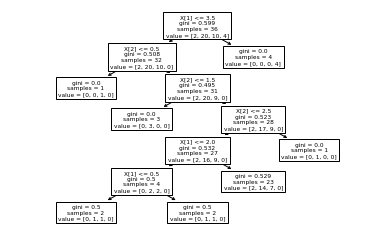

In [248]:
trained_model_A.visualize()

In [289]:
trained_model_A.predict_one("event", "executive_time", "meeting"),

('executive_time',)

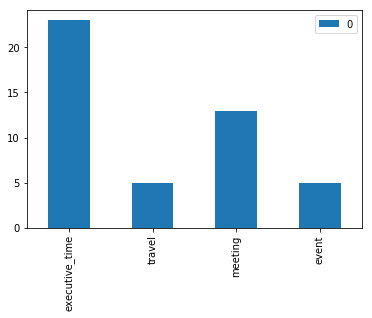

In [288]:
letter_counts = Counter(y)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.show()